In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix
from prompt_toolkit import validation
from sklearn.cluster import KMeans
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from utilities import clip_outliers, get_kfold, permutation_feature_importance
from models import neuralNetwork
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from scipy.stats import kstest
from scipy.stats import wilcoxon
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from scipy.stats import shapiro
from sklearn.model_selection import cross_val_score
from scipy.stats import pointbiserialr
from scipy.stats import ttest_rel
from sklearn.feature_selection import f_classif
from scipy.stats import mannwhitneyu
import numpy as np
from scipy.stats import boxcox
from sklearn.metrics import r2_score, root_mean_squared_error
from scipy.stats import levene
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import yeojohnson
from sklearn.decomposition import PCA
import torch.nn as nn
import torch
import torch.optim as optim

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Data Analysis: Soybean Cultivars

The Soybean Cultivars dataset provides features including plant height, insertion of the first pod, number of stems, number of legumes per plant, number of grains per plant, number of grains per pod/per plant, thousand seed weight, and grain yield of soyplant gathered during an experiment.

For additional information about the dataset and how the experiment was conducted, please refer to [this link](https://editorapantanal.com.br/journal/index.php/taes/article/view/8/5).

![Soyplant](soyplant.jpg)

After reviewing the dataset documentation and researching the appearance of soyplants, several assumptions can be made about the variables:

- The number of legumes per plant multiplied by the number of grains per pod should be equal to the number of grains per plant.
- There might be a correlation between plant height, the number of legumes per plant, and the insertion of the first pod.
- The number of stems may be correlated with the aforementioned factors.

Our initial focus will be on employing statistical methods and visual exploration to gain deeper insights into the data and its correlations. Subsequently, we'll explore methods for generating a new cultivar.


In [5]:
data = pd.read_csv('data/data.csv')

# Exploratory data analysis

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Season      320 non-null    int64  
 1   Cultivar    320 non-null    object 
 2   Repetition  320 non-null    int64  
 3   PH          320 non-null    float64
 4   IFP         320 non-null    float64
 5   NLP         320 non-null    float64
 6   NGP         320 non-null    float64
 7   NGL         320 non-null    float64
 8   NS          320 non-null    float64
 9   MHG         320 non-null    float64
 10  GY          320 non-null    float64
dtypes: float64(8), int64(2), object(1)
memory usage: 27.6+ KB


As stated in the dataset documentation there are no missing values and all the columns have the right data type.

In [7]:
data.describe()

,Season,Repetition,PH,IFP,NLP,NGP,NGL,NS,MHG,GY
count,320.000000,320.000000,320.000000,320.0000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000
mean,1.500000,2.500000,68.386781,15.4650,59.088313,135.085844,2.290844,4.071656,168.322313,3418.553794
std,0.500783,1.119785,8.958194,3.0243,20.068187,60.494529,0.840116,1.474531,19.625566,503.003602
min,1.000000,1.000000,47.600000,7.2000,20.200000,47.800000,0.940000,0.400000,127.060000,1538.230000
25%,1.000000,1.750000,62.950000,13.6000,44.350000,95.052500,2.000000,3.000000,153.845000,3126.611552
50%,1.500000,2.500000,67.200000,15.6000,54.500000,123.000000,2.280000,3.800000,166.150000,3397.276724
75%,2.000000,3.250000,74.347500,17.3300,71.220000,161.350000,2.480000,5.000000,183.182500,3708.262931
max,2.000000,4.000000,94.800000,26.4000,123.000000,683.400000,14.860000,9.000000,216.000000,4930.000000


Looking at number of grains per plant (NGP) we can see that the mean (sensitive to outliers) is significantly greater than the median, the same for number of legumes per plant (NLP).

In [8]:
float_cols = data.select_dtypes(include='float64').columns

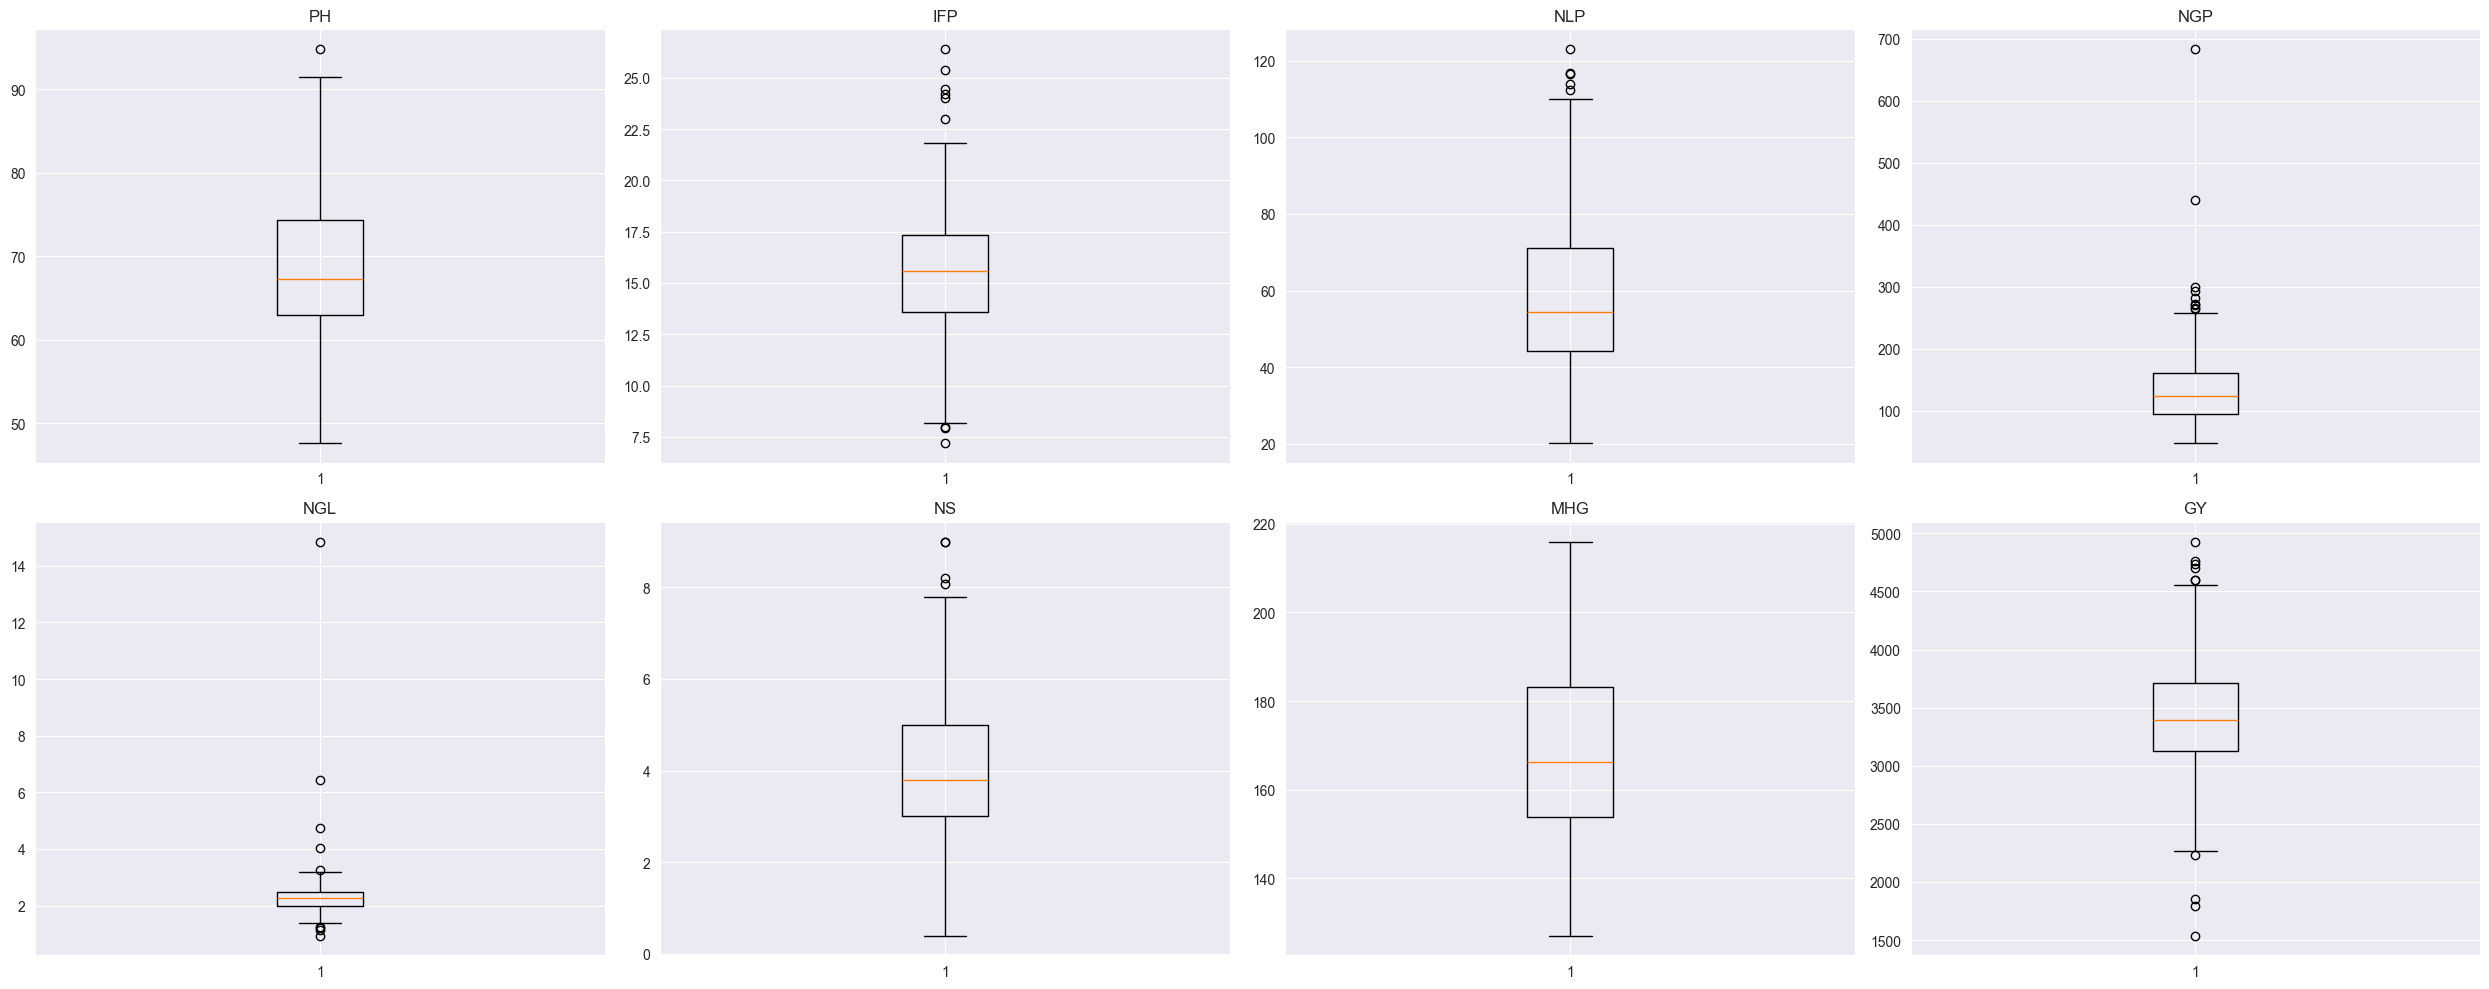

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(25,10))
cnt = 0
for i in range(2):
    for j in range(4):
        axs[i, j].boxplot(data[float_cols.tolist()[cnt]])
        axs[i, j].set_title(float_cols.tolist()[cnt])
        cnt += 1
fig.tight_layout()
plt.show()

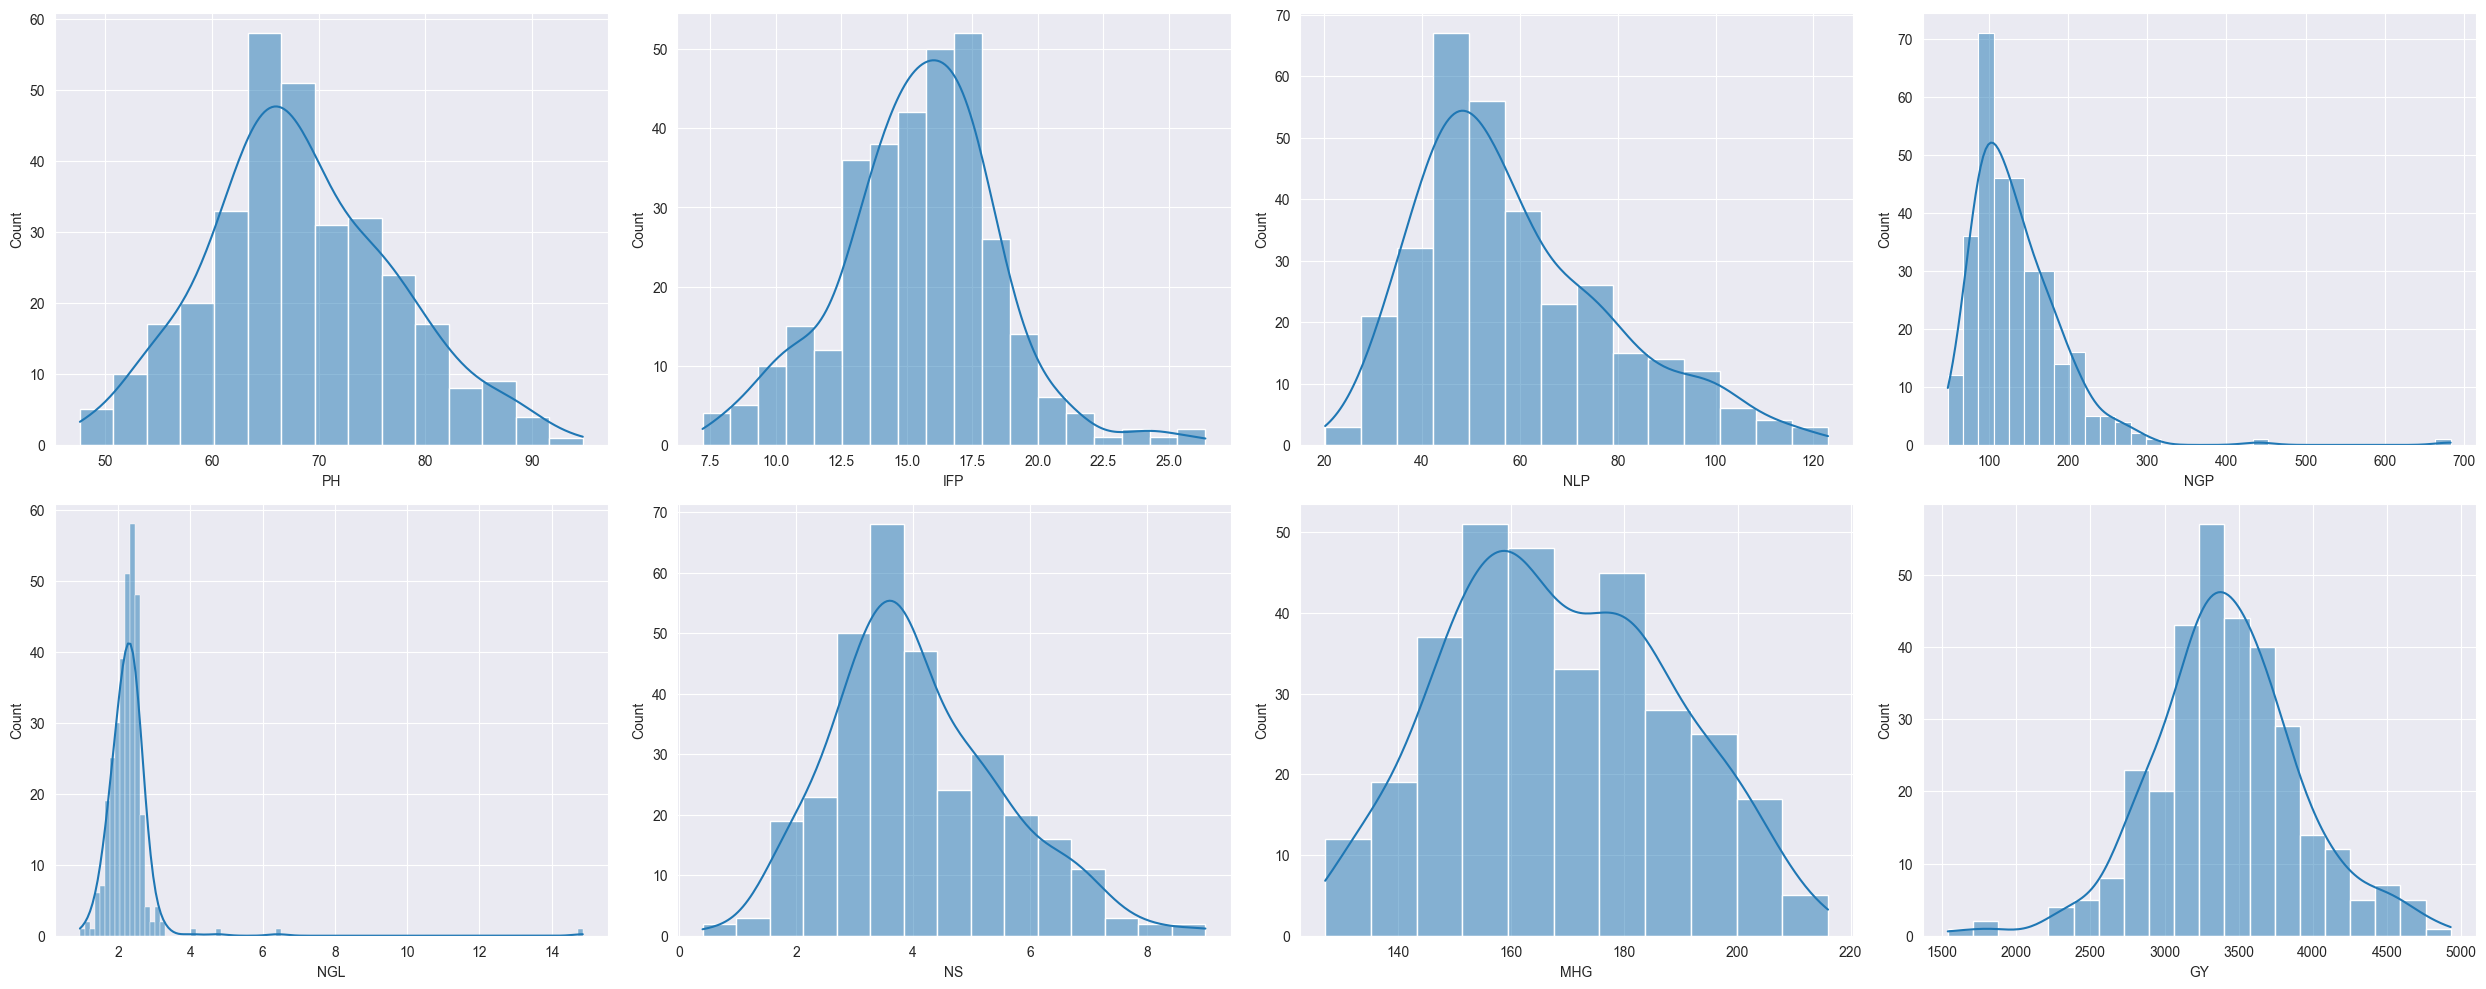

In [10]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(25,10))
cnt = 0
for i in range(2):
    for j in range(4):
        sns.histplot(data[float_cols.tolist()[cnt]], ax=axs[i,j], kde=True)
        cnt += 1
fig.tight_layout()
plt.show()

We can see that the number of grains per legume (NGL), the number of grains per plant (NGP) and IFP have a long positive tail, MHG has 2 peaks. GY have as well a negative tail. Further segmentation investigation needs to be done. There are some soy plants that have a lot of legumes therefore they have a lot of grains.

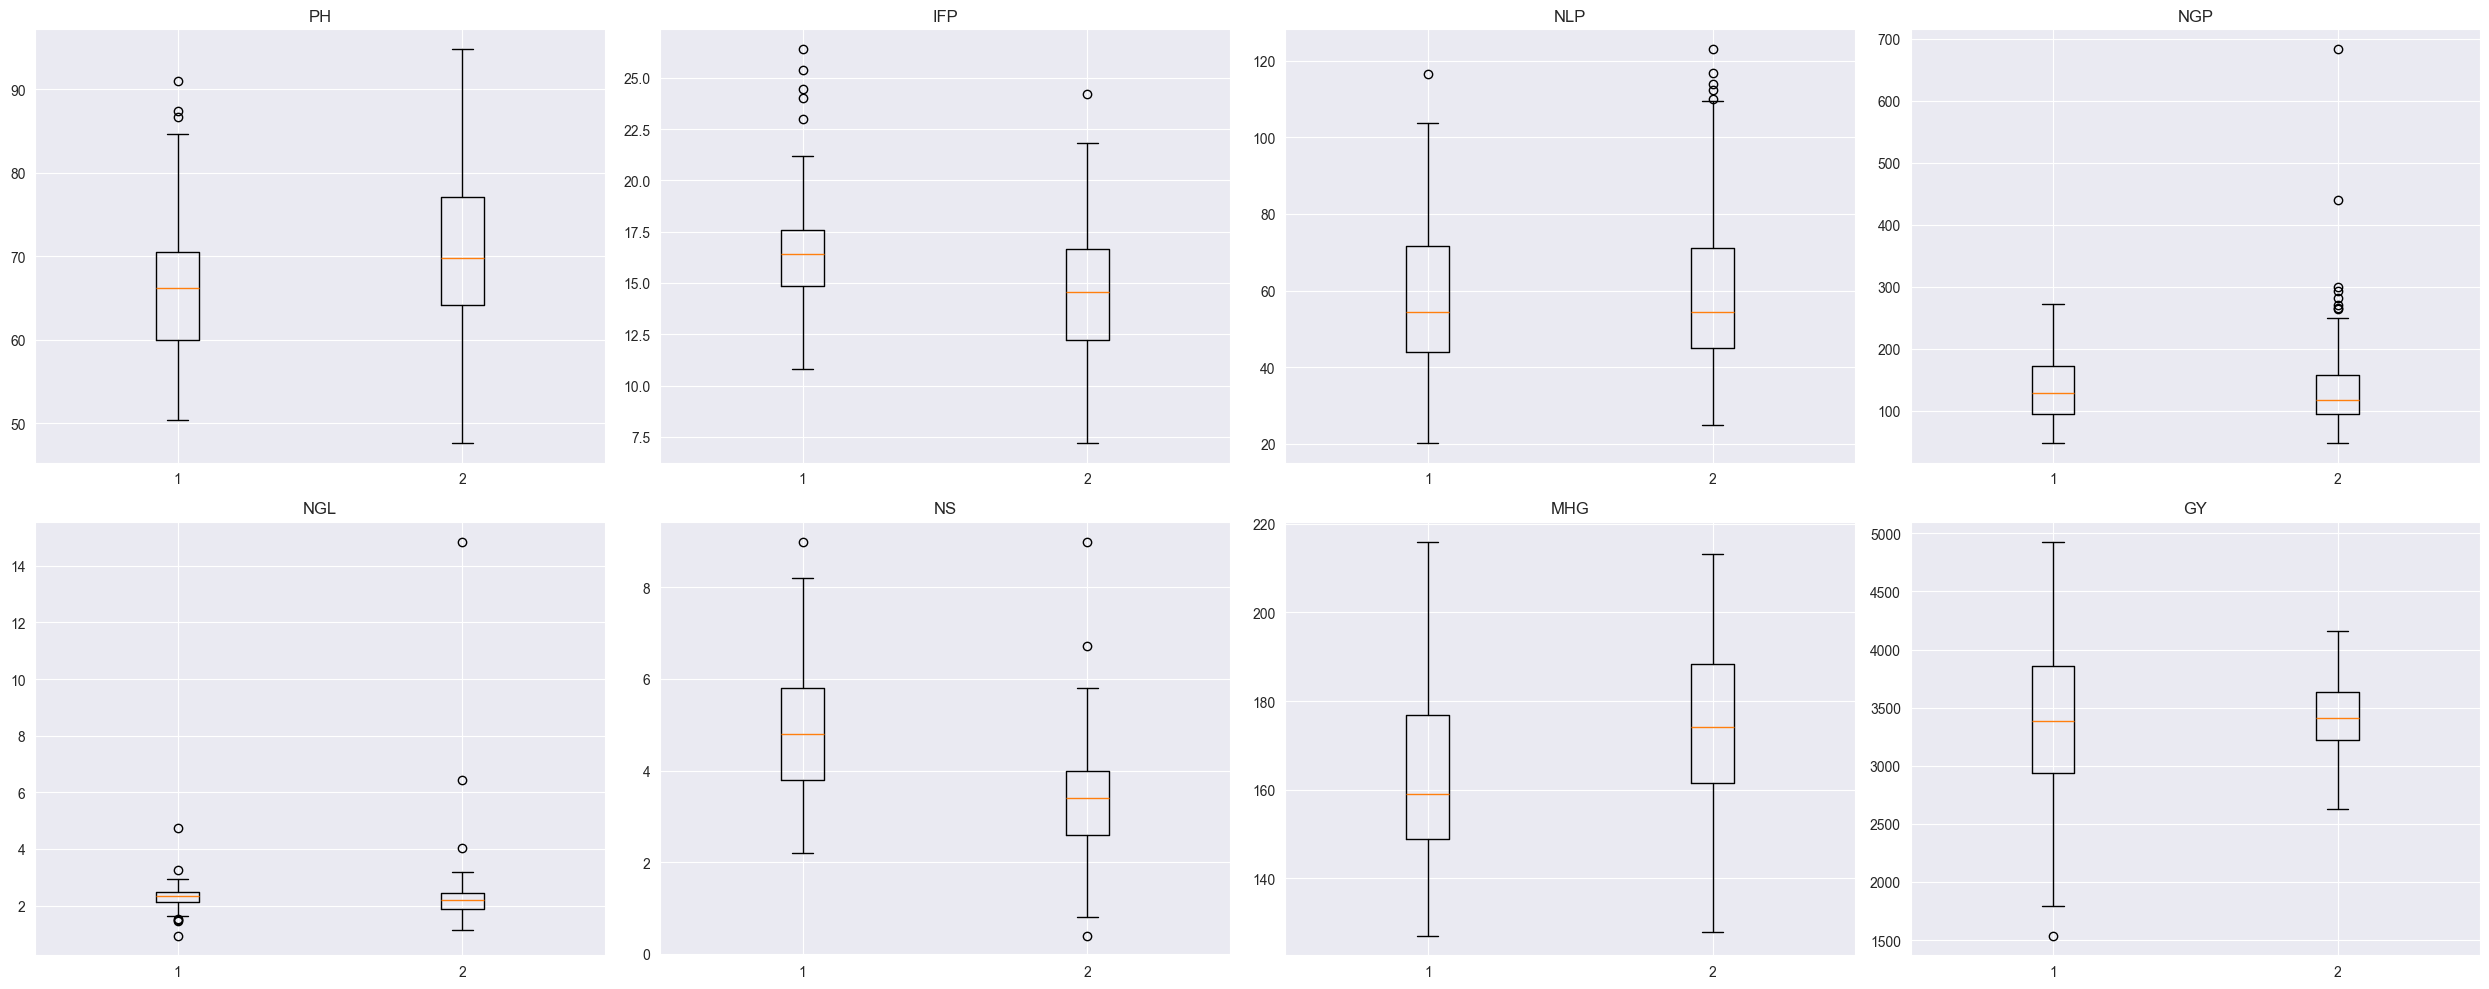

In [11]:
season1 = data[data.Season == 1]
season2 = data[data.Season == 2]
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(25,10))
cnt = 0
for i in range(2):
    for j in range(4):
        axs[i, j].boxplot([season1[float_cols.tolist()[cnt]], season2[float_cols.tolist()[cnt]]])
        axs[i, j].set_title(float_cols.tolist()[cnt])
        cnt += 1
fig.tight_layout()
plt.show()

If we split by season we observe that in general the plants from season 2 are taller, but the insertion of the first pod in lower and although they have less stems they roughly have the same number of grains. We can also think that there is a slight negative correlation between PH and NS when splitted by season, also lets take a look at distributions.

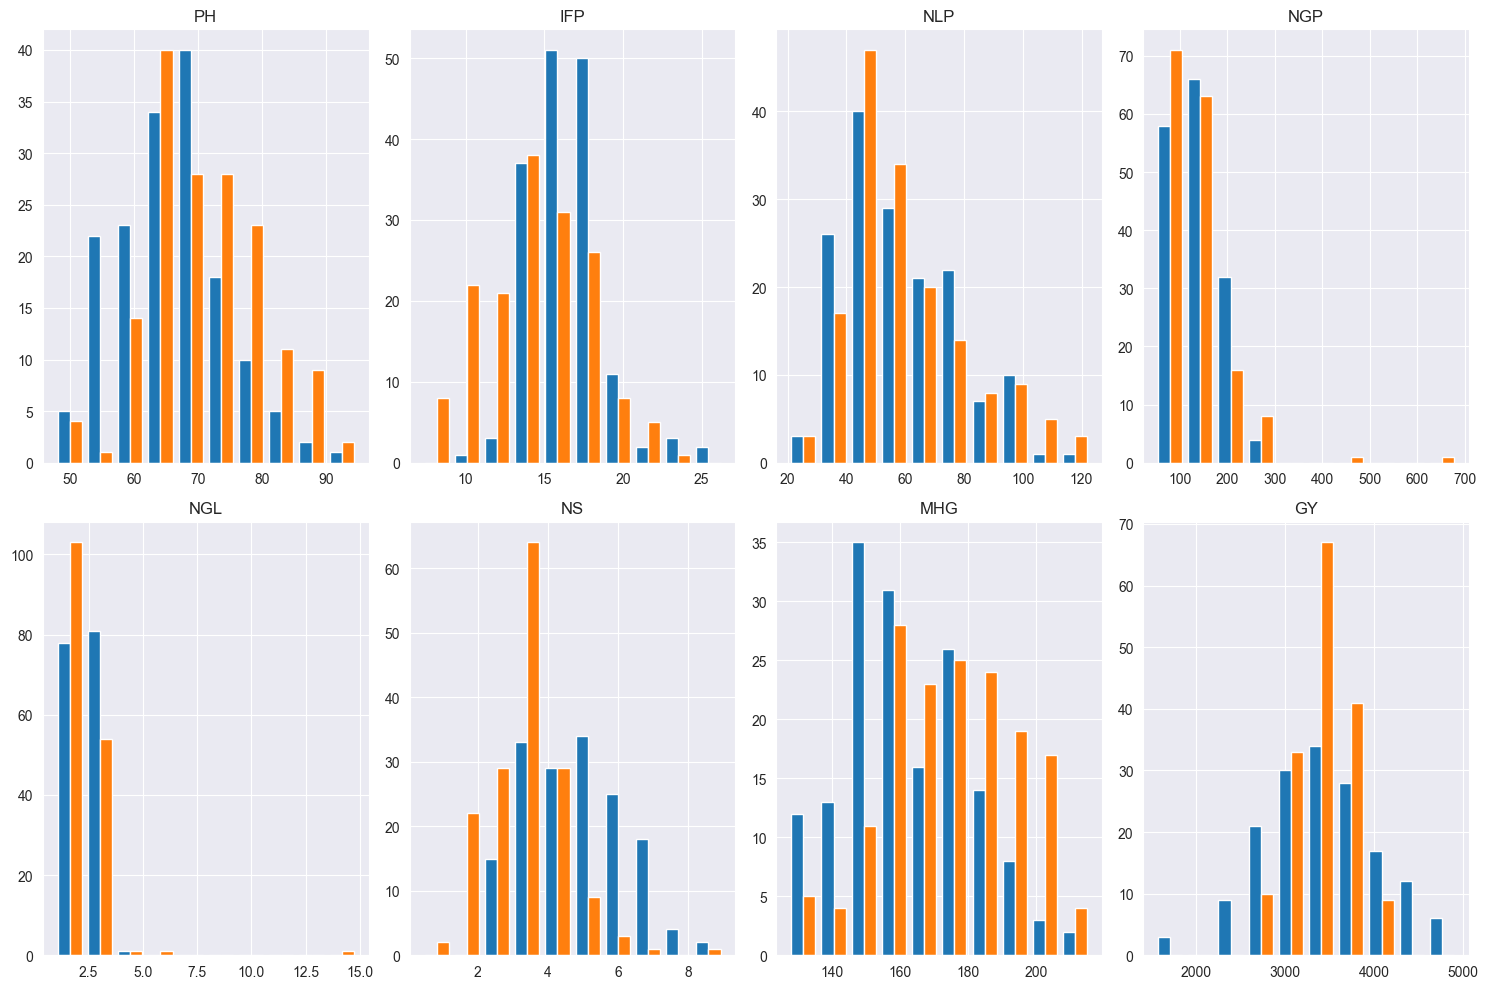

In [12]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15,10))
cnt = 0
for i in range(2):
    for j in range(4):
        axs[i, j].hist([season1[float_cols.tolist()[cnt]], season2[float_cols.tolist()[cnt]]])
        axs[i, j].set_title(float_cols.tolist()[cnt])
        cnt += 1
fig.tight_layout()
plt.show()

Further statistical tests needs to be done in order to determine if the season have a significant importance. But, for now, let's check for correlations.

C:\Users\Cata\AppData\Local\Temp\ipykernel_13680\54100882.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  scatter_matrix(data.select_dtypes(exclude='object'), ax=ax)


array([[<Axes: xlabel='Season', ylabel='Season'>,
        <Axes: xlabel='Repetition', ylabel='Season'>,
        <Axes: xlabel='PH', ylabel='Season'>,
        <Axes: xlabel='IFP', ylabel='Season'>,
        <Axes: xlabel='NLP', ylabel='Season'>,
        <Axes: xlabel='NGP', ylabel='Season'>,
        <Axes: xlabel='NGL', ylabel='Season'>,
        <Axes: xlabel='NS', ylabel='Season'>,
        <Axes: xlabel='MHG', ylabel='Season'>,
        <Axes: xlabel='GY', ylabel='Season'>],
       [<Axes: xlabel='Season', ylabel='Repetition'>,
        <Axes: xlabel='Repetition', ylabel='Repetition'>,
        <Axes: xlabel='PH', ylabel='Repetition'>,
        <Axes: xlabel='IFP', ylabel='Repetition'>,
        <Axes: xlabel='NLP', ylabel='Repetition'>,
        <Axes: xlabel='NGP', ylabel='Repetition'>,
        <Axes: xlabel='NGL', ylabel='Repetition'>,
        <Axes: xlabel='NS', ylabel='Repetition'>,
        <Axes: xlabel='MHG', ylabel='Repetition'>,
        <Axes: xlabel='GY', ylabel='Repetition'>],
    

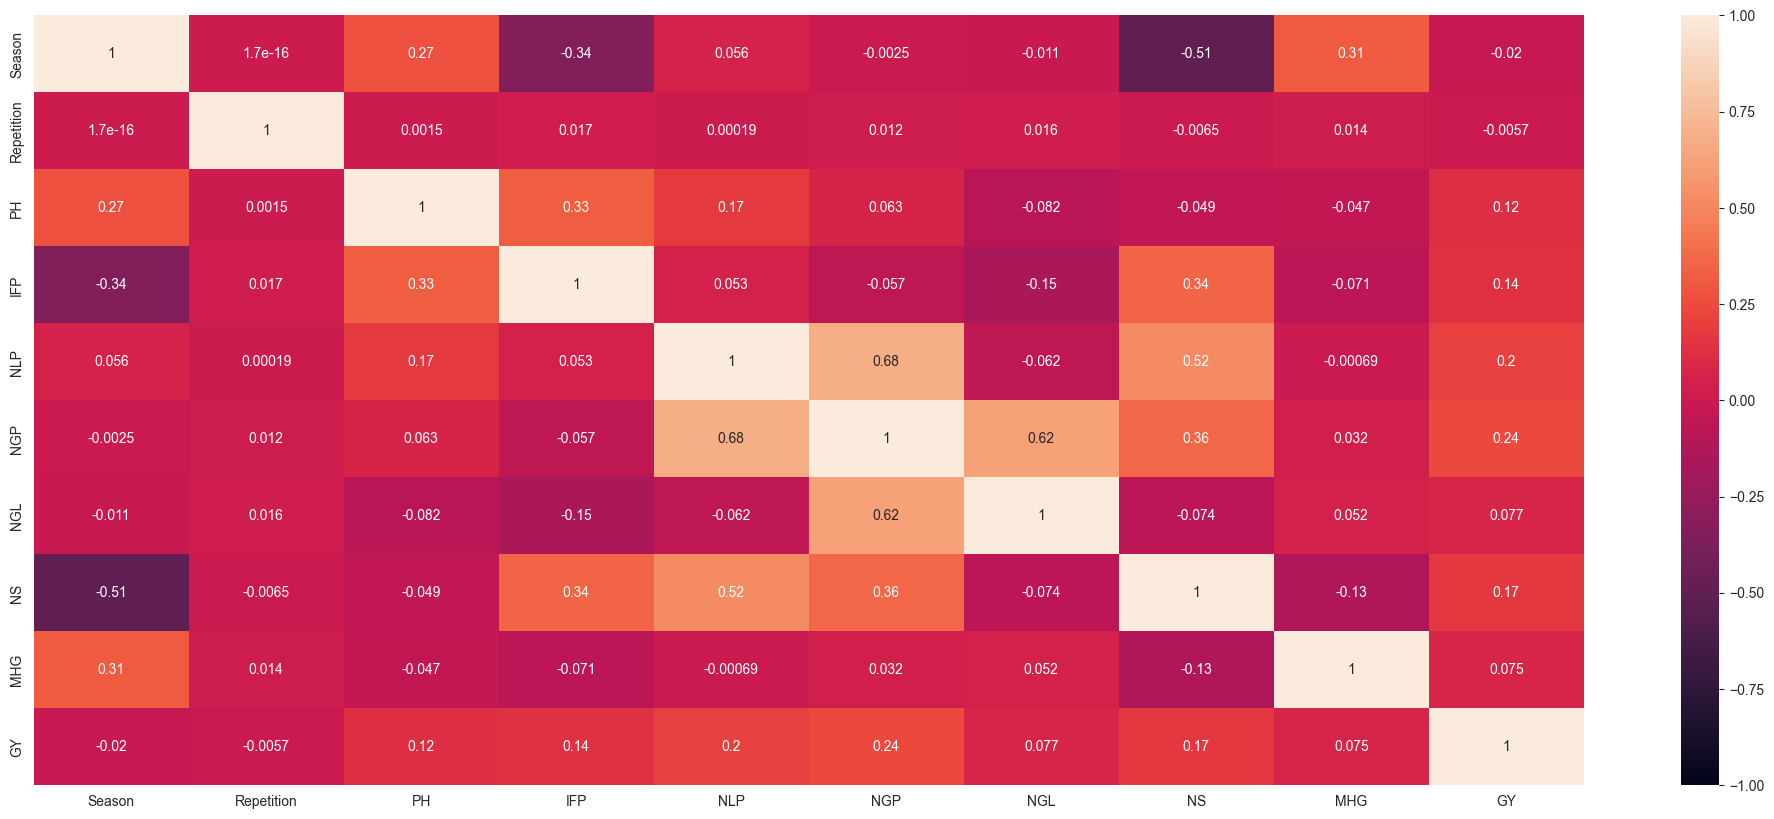

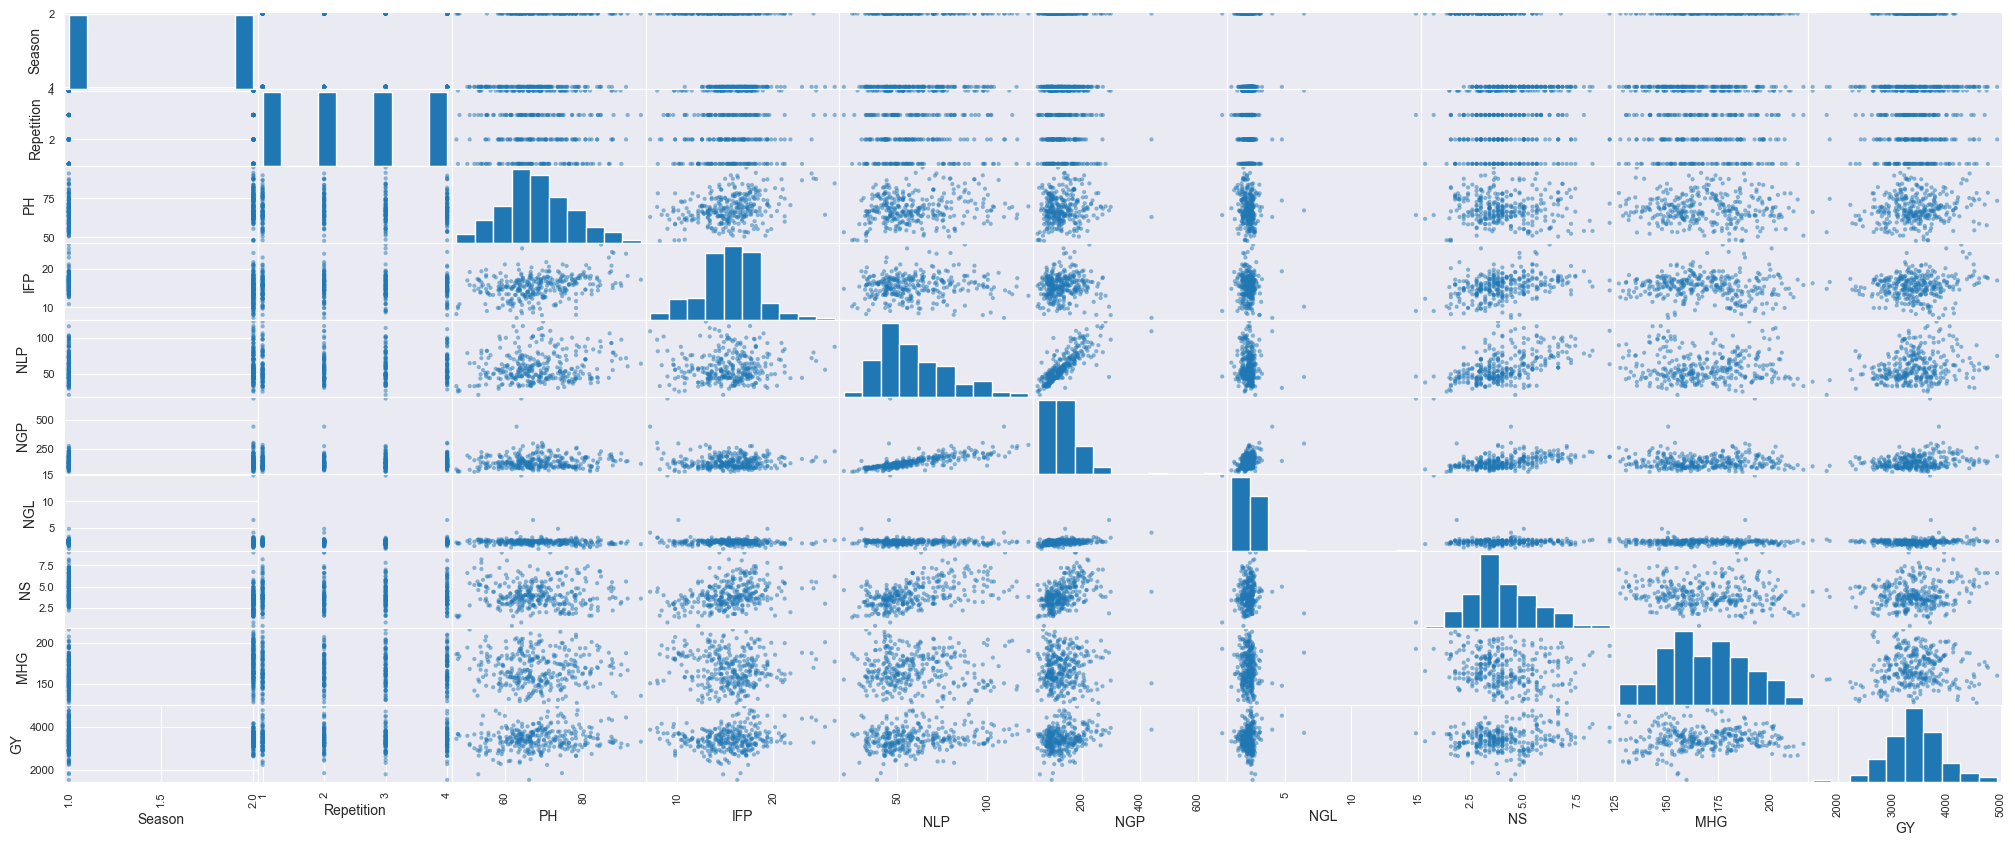

In [13]:
fig, ax = plt.subplots(1, figsize=(25,10))
sns.heatmap(data.select_dtypes(exclude='object').corr(), annot=True, vmin=-1, vmax=1)
fig, ax = plt.subplots(1, figsize=(25,10))
scatter_matrix(data.select_dtypes(exclude='object'), ax=ax)

Looking at the above plots we can derive the followings:
<li> There is a moderate linear negative relationship between season and number of stems. </li>
<li> Also season have weak correlations with IFP, PH, MHG. I'm guessing that one season is more potent than the other.</li>
<li> There is  a weak correlation between plant height and insertion of the first pod, I think that if a plant is taller, its first pod will be ata higher level.</li>
<li> As stated in the beggining there is a fairly strong positive correlation between the number of grains per plant (NGP), number of grain per legume (NGP), number of legumes per plant(NLP) and number of stems. The more stems <=> the more grains and so on. The actual causation needs to be determined</li>
<li>At first glance the repetion its not corelated with anything as it should.</li>

We need to gain more information in order to conclude if there is any causation or if a variable influences another variable.


Now let's explore the correlation between the number of grains per plant (NGP), the number of legumes per plant (NLP) and the number of grains per legume (NGL) as I expect a strong linear relationship. In addition we will explore number of stems (NS) and insertion of first plant (IFP).

In [14]:
interest_fiels = data[['NGP', 'NLP', 'NGL', 'NS', 'IFP']]
X = interest_fiels[['NLP', 'NGL', 'IFP', 'NS']]
X = sm.add_constant(X)
model = sm.OLS(interest_fiels['NGP'], X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    NGP   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     783.7
Date:                Thu, 11 Apr 2024   Prob (F-statistic):          2.75e-162
Time:                        20:29:55   Log-Likelihood:                -1383.4
No. Observations:                 320   AIC:                             2777.
Df Residuals:                     315   BIC:                             2796.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -104.3436      7.149    -14.595      0.0

the t value of IFP is small, so we can drop it.

In [15]:
interest_fiels = data[['NGP', 'NLP', 'NGL', 'NS', 'IFP']]
X = interest_fiels[['NLP', 'NGL', 'NS']]
X = sm.add_constant(X)
model = sm.OLS(interest_fiels['NGP'], X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    NGP   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     1047.
Date:                Thu, 11 Apr 2024   Prob (F-statistic):          8.97e-164
Time:                        20:29:56   Log-Likelihood:                -1383.6
No. Observations:                 320   AIC:                             2775.
Df Residuals:                     316   BIC:                             2790.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -107.1683      4.676    -22.920      0.0

In [16]:
interest_fiels = data[['NGP', 'NLP', 'NGL', 'NS', 'IFP']]
X = interest_fiels[['NLP', 'NGL']]
X = sm.add_constant(X)
model = sm.OLS(interest_fiels['NGP'], X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    NGP   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     1551.
Date:                Thu, 11 Apr 2024   Prob (F-statistic):          2.04e-164
Time:                        20:29:57   Log-Likelihood:                -1385.9
No. Observations:                 320   AIC:                             2778.
Df Residuals:                     317   BIC:                             2789.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -103.6619      4.410    -23.506      0.0

All the t values are high, so this confirm my hyppotesys in the beggining. By looking at R-squared we see that 90% of variation in NGP is explained by NLP and NGL. 
One more step is to use Variance Inflation Factor to determine multicolinearity.

In [17]:
X = data[float_cols]
X = sm.add_constant(X)
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])],index=X.columns)
vif

const    234.065199
PH         1.299685
IFP        1.444429
NLP        6.943006
NGP       11.181433
NGL        5.941540
NS         1.854215
MHG        1.039961
GY         1.111192
dtype: float64

We will drop the number of grains per plant for future models as it's higly collinear with NLP and NGL.

In [18]:
data = data.drop('NGP', axis=1)

In [19]:
X = data[data.select_dtypes(include='float64').columns]
X = sm.add_constant(X)
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])],index=X.columns)
vif

const    191.102635
PH         1.299685
IFP        1.441628
NLP        1.605257
NGL        1.042131
NS         1.830815
MHG        1.039961
GY         1.088674
dtype: float64

Now our data looks good, without multicolinearity.

# Let's look at how variables affect thousand seed weight (MHG)

Looking at the correlation matrix MHG is slighty correlated with Season, in order to determine the most important factors that influence MHG we will use linear regression. But one more thing before is to decide why its histogram has 2 peaks. By looking at the boxplots we can see that when splitted by season, MHG has in general higher values in season 2.

<Axes: xlabel='MHG', ylabel='Count'>

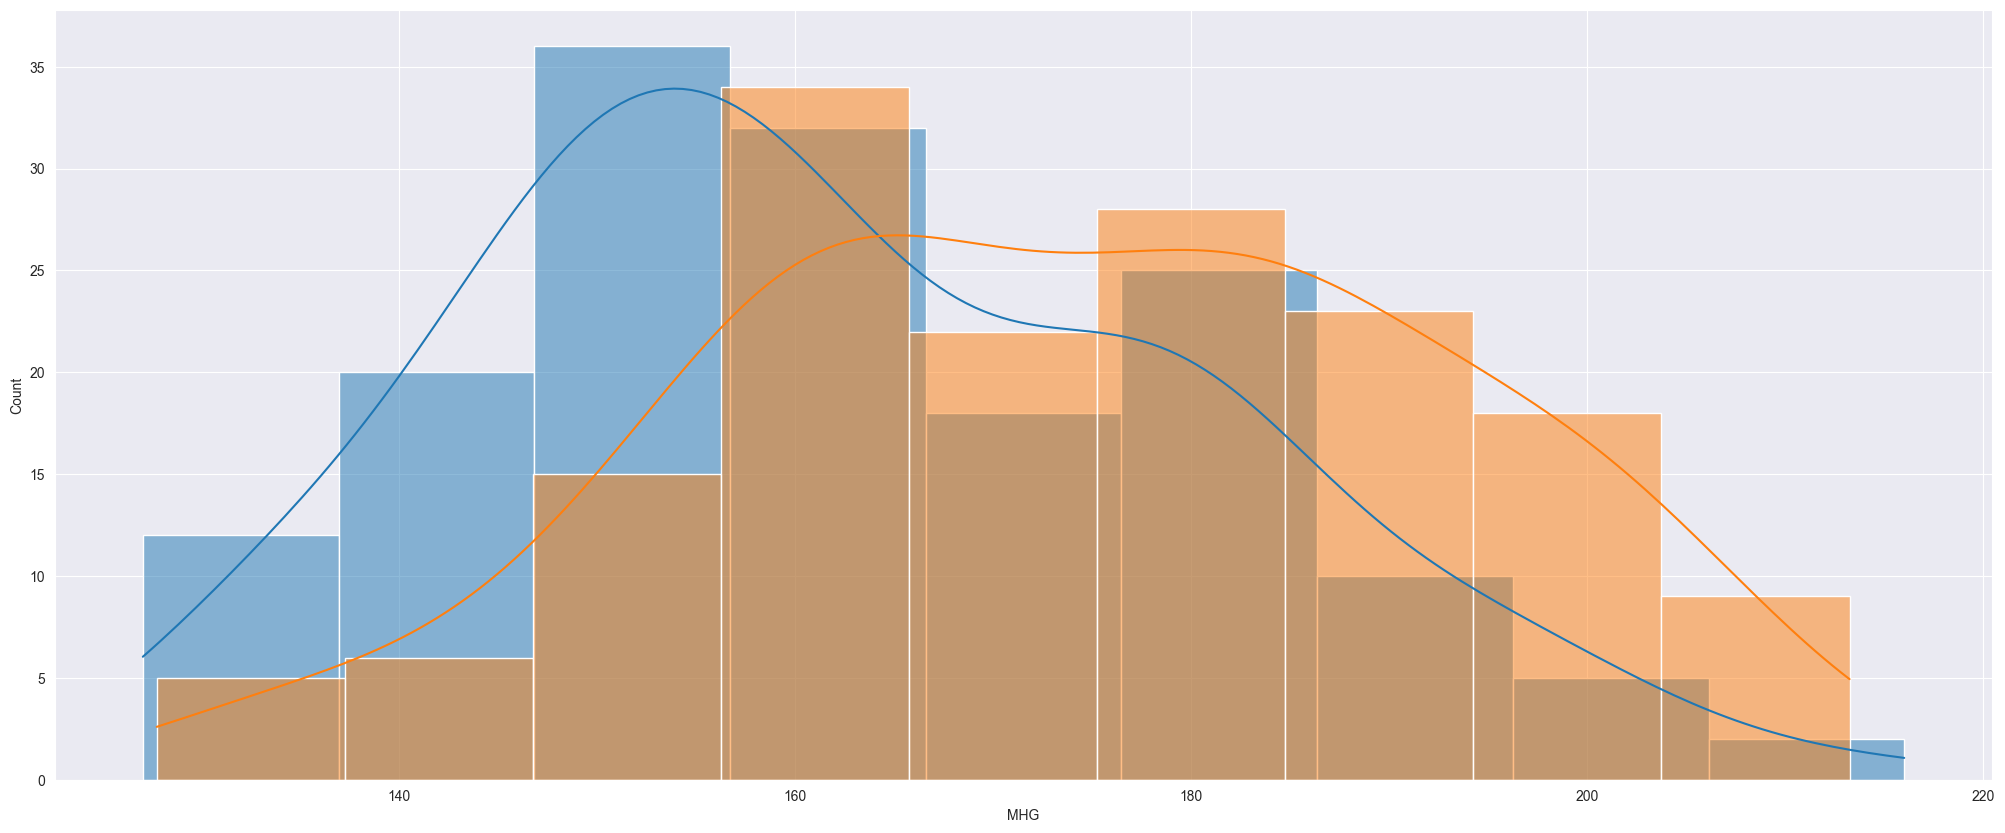

In [20]:
fig, ax = plt.subplots(1, figsize=(25,10))
sns.histplot(data[data.Season == 1].MHG, ax=ax, kde=True)
sns.histplot(data[data.Season == 2].MHG, ax=ax, kde=True)

By looking at the distribution we can clearly see 2 different populations, now we will apply statistical test to formaly confirm this assumption.

In [21]:
pearsonr(data[data.Season == 1].MHG, data[data.Season == 2].MHG)

PearsonRResult(statistic=0.7680928126548011, pvalue=2.1250348001233834e-32)

The distributions are higly correlated so we will apply Wilcoxon signed-rank tes.

In [22]:
wilcoxon(data[data.Season == 1].MHG, data[data.Season == 2].MHG)

WilcoxonResult(statistic=1116.0, pvalue=1.1876423202035815e-19)

P-Value is very small so we can conclude that there is strong evidence to suggest that the distributions seasons are in fact different and explain the bimodal distribution.

To process the data for linear regression analysis we will drop Cultival and Repetition columns, as they have no effect on MHG, and we will one hot encode Season.

In [23]:
mhg_model_data = data.drop(['Cultivar', 'Repetition'], axis=1)
mhg_model_data['IsSeason1'] = mhg_model_data['Season'] == 1
mhg_model_data = mhg_model_data.drop('Season', axis=1)
mhg_model_data['IsSeason1'] = mhg_model_data['IsSeason1'].apply(int)

In [24]:
X = mhg_model_data.drop('MHG', axis=1)
X = sm.add_constant(X)
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])],index=X.columns)
vif

const        113.908803
PH             1.417197
IFP            1.557817
NLP            1.787290
NGL            1.046147
NS             2.422229
GY             1.080115
IsSeason1      1.874789
dtype: float64

As a note, because Season is binary. we will not introduce 'IsSeason2' as its equal to 1 - IsSeason1 and we dont want to introduce multicolinearity.

In [25]:
y = mhg_model_data['MHG']
X = mhg_model_data.drop('MHG', axis=1)
X = sm.add_constant(X)
linear_model = sm.OLS(y, X)
res = linear_model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    MHG   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     7.026
Date:                Thu, 11 Apr 2024   Prob (F-statistic):           8.62e-08
Time:                        20:30:19   Log-Likelihood:                -1382.7
No. Observations:                 320   AIC:                             2781.
Df Residuals:                     312   BIC:                             2812.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        179.7310     11.004     16.333      0.0

<Axes: ylabel='Count'>

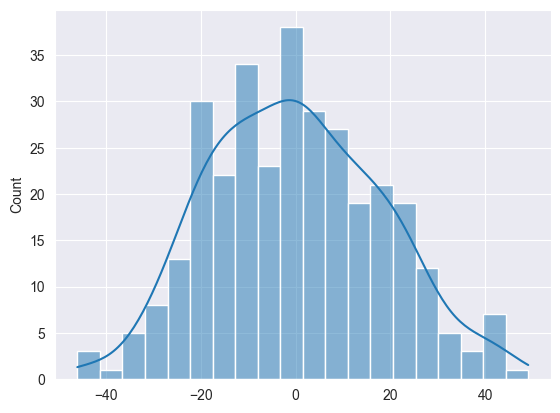

In [26]:
residuals = res.resid
sns.histplot(residuals, bins=20, kde=True)

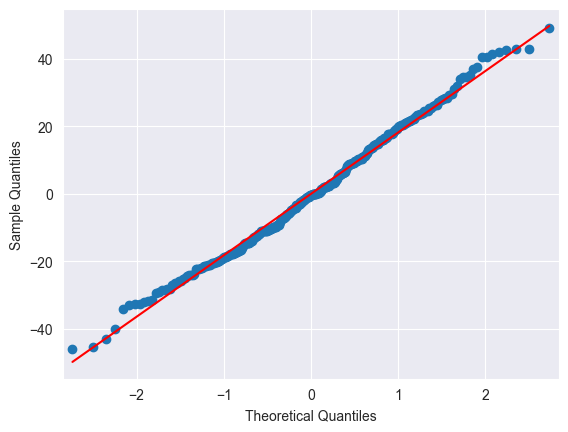

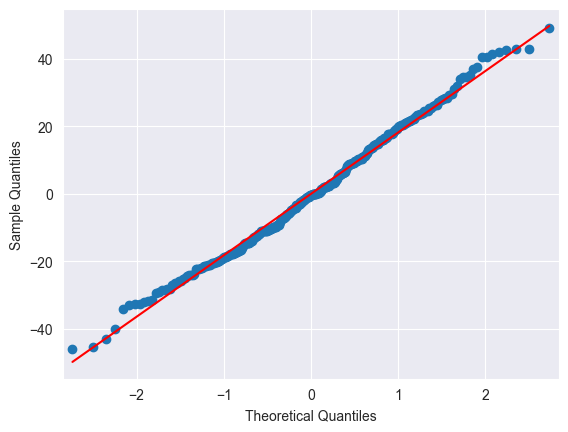

In [27]:
sm.qqplot(residuals, line='s')

In [28]:
root_mean_squared_error(res.fittedvalues, y)

18.211956214352064

In [29]:
a = pd.DataFrame({'fitted':res.fittedvalues, 'actual':y})
a

,fitted,actual
0,162.098007,152.20
1,162.769920,141.69
2,163.282712,148.81
3,162.485818,148.50
4,155.640257,145.59
...,...,...
315,167.122572,135.19
316,178.451876,145.69
317,178.887292,147.24
318,178.449997,156.32


By the plots above the residals have in fact a normal distribution. By looking at t-statistic and p value we can observe that the most important factors in dermining MHG are Season and Plant Height.

We will also use a neural network to fit our data and will use permutation feature importance to get the most important, feature. The same aproach will be used for Grain Yield.

In [30]:
mhg_model_data = mhg_model_data.sample(frac=1)
train_data, validation_data = train_test_split(mhg_model_data, test_size=0.1)
train_data = train_data.reset_index()
validation_data = validation_data.reset_index()
X_train = train_data.drop('MHG', axis=1)
y_train = train_data['MHG']
X_validation = validation_data.drop('MHG', axis=1)
y_validation = validation_data['MHG']
X_train.drop('index', axis=1, inplace=True)
X_validation.drop('index', axis=1, inplace=True)

In [31]:
from sklearn.preprocessing import StandardScaler
float_cols = X_train.select_dtypes(include='float64').columns
scaler = StandardScaler()
scaler.fit(X_train[float_cols])
X_train[float_cols] = scaler.transform(X_train[float_cols])
X_validation[float_cols] = scaler.transform(X_validation[float_cols])

In [32]:
import utilities
model = neuralNetwork.SoyBeanNetwork(len(X_train.columns)).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_losses, val_lossses = utilities.train(model, 100, criterion, optimizer, X_train, y_train, X_validation, y_validation)

OK


<Axes: >

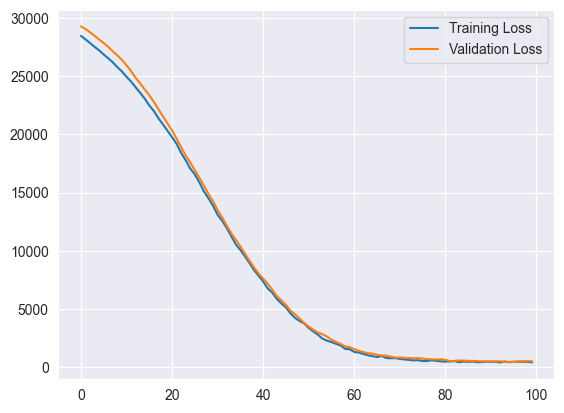

In [33]:
sns.lineplot(train_losses, label='Training Loss')
sns.lineplot(val_lossses, label='Validation Loss')

In [34]:
y_train_pred = model(torch.tensor(X_train.to_numpy(), dtype=torch.float).to(device)).cpu().detach().numpy()
y_val_pred = model(torch.tensor(X_validation.to_numpy(), dtype=torch.float).to(device)).cpu().detach().numpy()

In [35]:
print(root_mean_squared_error(y_train_pred.squeeze(1), y_train.to_numpy()), root_mean_squared_error(y_val_pred.squeeze(1), y_validation.to_numpy()))

19.981609411948828 26.13360816435448


In [36]:
import utilities
importances = utilities.permutation_feature_importance(model, X_validation, y_validation, root_mean_squared_error, n_repeats=10000)

aux = [(feat_name, imp) for feat_name, imp in zip(X_train.columns, importances)]
aux = sorted(aux, key=lambda x: x[1], reverse=True)
aux

[('IsSeason1', 6.26965642605278),
 ('NS', 5.763700819741501),
 ('GY', 4.937290664461514),
 ('NGL', 3.7229857998375344),
 ('IFP', 3.672571500201844),
 ('NLP', 3.643743736814937),
 ('PH', 3.3208161028176875)]

By looking at the above values we can conclude that the most important factors in determining MHG are NS and the Season. In contrast to the linear regression PH is the least importance, it can be related to the fact that the linear regresseion did a poor job, hacing a R-squared value of 0.13 (it explains only 13% of the variation).

# Let's look at how variables affect grain yield (GY)

In [37]:
gy_model_data = data.drop(['Cultivar', 'Repetition'], axis=1)
gy_model_data['IsSeason1'] = gy_model_data['Season'] == 1
gy_model_data = gy_model_data.drop('Season', axis=1)
gy_model_data['IsSeason1'] = gy_model_data['IsSeason1'].apply(int)

In [38]:
X = gy_model_data.drop('GY', axis=1)
X = sm.add_constant(X)
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])],index=X.columns)
vif

const        194.550768
PH             1.455614
IFP            1.564482
NLP            1.765848
NGL            1.036348
NS             2.417332
MHG            1.148525
IsSeason1      2.086910
dtype: float64

We make sure that there is no colinearity.

In [39]:
y = gy_model_data['GY']
X = gy_model_data.drop(['GY'], axis=1)
X = sm.add_constant(X)
linear_model = sm.OLS(y, X)
res = linear_model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     GY   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     3.953
Date:                Thu, 11 Apr 2024   Prob (F-statistic):           0.000374
Time:                        20:31:37   Log-Likelihood:                -2430.6
No. Observations:                 320   AIC:                             4877.
Df Residuals:                     312   BIC:                             4907.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1970.0477    380.084      5.183      0.0

<Axes: ylabel='Count'>

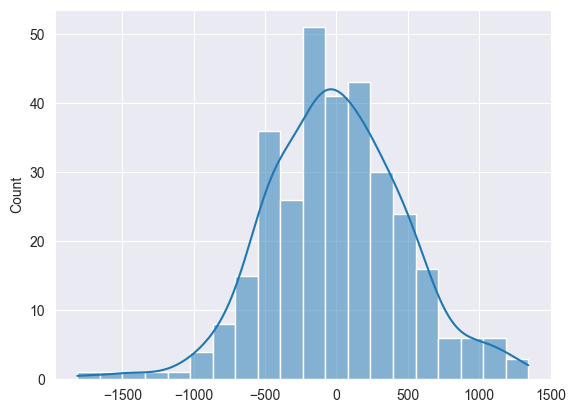

In [40]:
residuals = res.resid
sns.histplot(residuals, bins=20, kde=True)

In [41]:
root_mean_squared_error(res.fittedvalues, y)

481.3275667802689

In [42]:
a = pd.DataFrame({'fitted':res.fittedvalues, 'actual':y})
a

,fitted,actual
0,3473.601191,3232.820000
1,3489.523775,3517.360000
2,3585.467867,3391.460000
3,3518.238015,3312.580000
4,3668.443922,3230.990000
...,...,...
315,3467.481955,3348.931034
316,3406.098465,3418.850575
317,3587.196730,3651.586207
318,3366.627012,3487.931034


In [43]:
gy_model_data = gy_model_data.sample(frac=1)
train_data, validation_data = train_test_split(gy_model_data, test_size=0.1)
train_data = train_data.reset_index()
validation_data = validation_data.reset_index()
X_train = train_data.drop('GY', axis=1)
y_train = train_data['GY']
X_validation = validation_data.drop('GY', axis=1)
y_validation = validation_data['GY']
X_train.drop('index', axis=1, inplace=True)
X_validation.drop('index', axis=1, inplace=True)

In [44]:
from sklearn.preprocessing import StandardScaler
float_cols = X_train.select_dtypes(include='float64').columns
scaler = StandardScaler()
scaler.fit(X_train[float_cols])
X_train[float_cols] = scaler.transform(X_train[float_cols])
X_validation[float_cols] = scaler.transform(X_validation[float_cols])

In [45]:
import utilities
model = neuralNetwork.SoyBeanNetwork(len(X_train.columns)).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_losses, val_lossses = utilities.train(model, 500, criterion, optimizer, X_train, y_train, X_validation, y_validation)

OK


<Axes: >

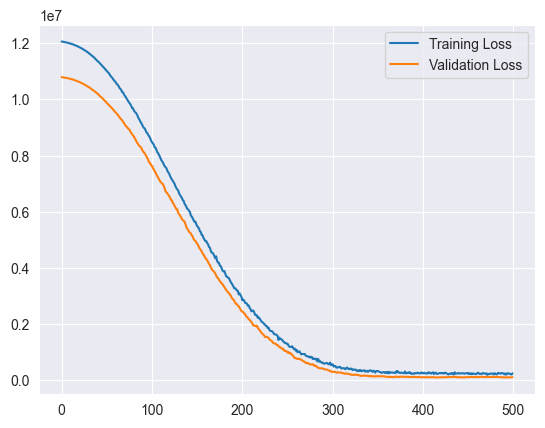

In [46]:
sns.lineplot(train_losses, label='Training Loss')
sns.lineplot(val_lossses, label='Validation Loss')

In [47]:
y_train_pred = model(torch.tensor(X_train.to_numpy(), dtype=torch.float).to(device)).cpu().detach().numpy()
y_val_pred = model(torch.tensor(X_validation.to_numpy(), dtype=torch.float).to(device)).cpu().detach().numpy()

In [48]:
print(root_mean_squared_error(y_train_pred.squeeze(1), y_train.to_numpy()), root_mean_squared_error(y_val_pred.squeeze(1), y_validation.to_numpy()))

468.4040500565282 485.7462811708154


In [49]:
import utilities
importances = utilities.permutation_feature_importance(model, X_validation, y_validation, root_mean_squared_error, n_repeats=100000)

aux = [(feat_name, imp) for feat_name, imp in zip(X_train.columns, importances)]
aux = sorted(aux, key=lambda x: x[1], reverse=True)
aux

[('IsSeason1', 149.75729991858958),
 ('NS', 140.70148621948016),
 ('MHG', 131.05133926000093),
 ('PH', 123.13942665876635),
 ('NGL', 120.66693336568807),
 ('IFP', 115.36385899661394),
 ('NLP', 77.93880294680395)]

It looks like the same 2 features are also important in predicting Grain Yield. Its interesting the fact that MHG is third place for GY and the same otherwise.

# Let's create a new cultivar

To generate a new cultivar we will use a Variational Autoencoder. We will use one for each season.

In [5]:
data_season1 = data[data['Season'] == 1]
data_season2 = data[data['Season'] == 2]
data_season1 = data_season1.drop('Cultivar', axis=1)
data_season1 = data_season1.drop('Season', axis=1)
data_season1 = data_season1.drop('Repetition', axis=1)
data_season2 = data_season2.drop('Cultivar', axis=1)
data_season2 = data_season2.drop('Season', axis=1)
data_season2 = data_season2.drop('Repetition', axis=1)

In [6]:
X_season1 = data_season1.to_numpy()
X_season2 = data_season2.to_numpy()

In [7]:
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
scaler2 = StandardScaler()
X_season1 = scaler1.fit_transform(X_season1)
X_season2 = scaler2.fit_transform(X_season2)

In [8]:
from models import VAE

model_season1 = VAE.VariationalAutoencoder(X_season1.shape[1], 32, 32, 8).to(device)
model_season2 = VAE.VariationalAutoencoder(X_season2.shape[1], 32, 32, 8).to(device)
criterion = VAE.vae_loss()

In [10]:
import utilities
optimizer_season1 = optim.Adam(model_season1.parameters(), lr=1e-3)
train_losses = utilities.train_vae(model_season1, X_season1, criterion, optimizer_season1, 3000)

<Axes: >

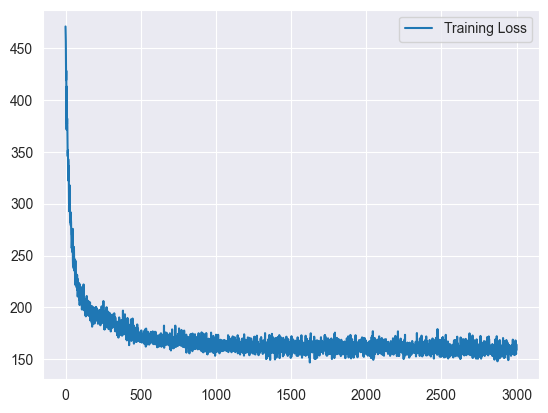

In [11]:
sns.lineplot(train_losses, label='Training Loss')

In [24]:
model_season1.eval()
model_season1(torch.tensor(X_season1[0], dtype=torch.float, device=device).unsqueeze(0))[0].cpu().detach().numpy()

array([[-0.33135447, -0.4700531 ,  1.6568    , -0.5672012 ,  0.82478464,
        -0.5669657 ,  0.15686628]], dtype=float32)

In [15]:
X_season1[0]

array([-0.86704035, -0.55165535,  2.08678349, -1.32681293,  0.27541088,
       -0.54911362, -0.3070977 ])

I cant get my implementation of VAE to work properly and due to time considerations i will use a library: https://docs.sdv.dev/sdv

In [44]:
data_season1 = data[data['Season'] == 1]
data_season1 = data_season1.drop('Cultivar', axis=1)
data_season1 = data_season1.drop('Season', axis=1)
data_season1 = data_season1.drop('Repetition', axis=1)

<Axes: >

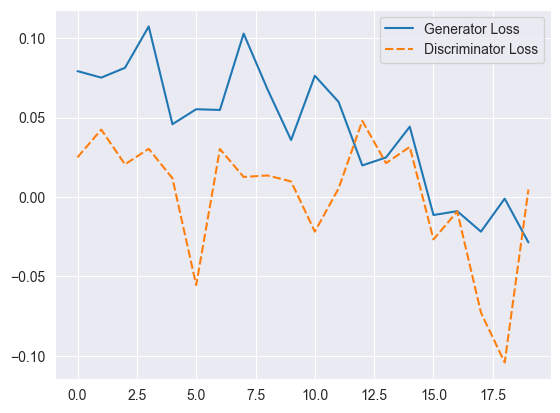

In [46]:
from ctgan import CTGAN

ctgan = CTGAN(epochs=20)
ctgan.fit(data_season1)
sns.lineplot(ctgan.loss_values[['Generator Loss', 'Discriminator Loss']])

In [6]:
from sdv.single_table import TVAESynthesizer
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
data_copy = data.drop('Repetition', axis=1)
metadata.detect_from_dataframe(data_copy)
synthesizer = TVAESynthesizer(metadata)
synthesizer.fit(data_copy)

C:\Users\Cata\SoybeanCultivars\lib\site-packages\sdv\single_table\base.py:80: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


<Axes: xlabel='Epoch', ylabel='Loss'>

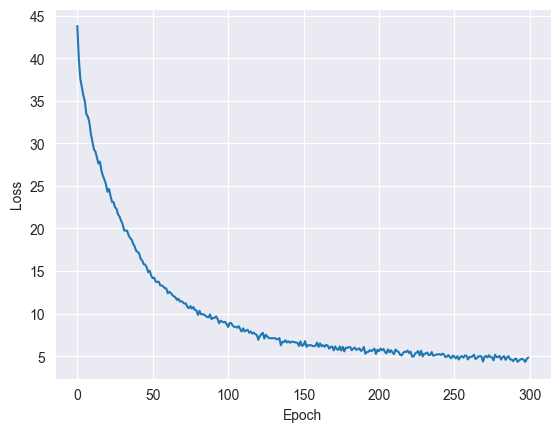

In [7]:
losses = synthesizer.get_loss_values()
epoch_losses = losses.groupby('Epoch')['Loss'].mean()
sns.lineplot(epoch_losses)

I added my own function to the library to generate samples given a latent point, so i get similar ones, because the same cultivar have similar values per season given repetitions.

In [129]:
new_data = synthesizer.sample_from_same_latent_space(100000, latent_space=torch.rand(500, 128).to(device), std=0.01)

C:\Users\Cata\SoybeanCultivars\lib\site-packages\ctgan\data_transformer.py:196: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.09095753 -0.2907236  -0.21598045 ... -0.21771437 -0.36998756
 -0.36848847]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  data.iloc[:, 0] = selected_normalized_value
C:\Users\Cata\SoybeanCultivars\lib\site-packages\ctgan\data_transformer.py:196: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.05763619 -0.29290486 -0.07631533 ... -0.28398146 -0.41256301
 -0.35362714]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  data.iloc[:, 0] = selected_normalized_value
C:\Users\Cata\SoybeanCultivars\lib\site-packages\ctgan\data_transformer.py:196: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future 

In [130]:
def get_new_cultivar():
    generated_cultivars = set(new_data['Cultivar'])
    for cultivar in generated_cultivars:
        season1 = new_data[new_data.Cultivar == cultivar]
        season1 = season1[season1.Season == 1]

        season2 = new_data[new_data.Cultivar == cultivar]
        season2 = season2[season2.Season == 2]
        if len(season1) >= 4 and len(season2) >= 4:
            return pd.concat([season1[:4], season2[:4]]) 

In [137]:
new_cultivar = get_new_cultivar()
new_cultivar['Cultivar'] = new_cultivar['Cultivar'].apply(lambda x: 'Generated Cultivar')
new_cultivar['Repetition'] = [1, 2, 3, 4, 1, 2, 3, 4]
new_cultivar

,Season,Cultivar,PH,IFP,NLP,NGL,NS,MHG,GY,Repetition
79,1,Generated Cultivar,64.319517,14.228286,44.613341,2.437308,3.080453,155.864570,3252.236429,1
428,1,Generated Cultivar,61.657241,13.094425,55.746634,2.447215,3.841155,163.901784,2820.460230,2
579,1,Generated Cultivar,64.962633,17.048775,43.143614,2.173343,2.381629,152.071928,3149.057141,3
928,1,Generated Cultivar,64.245922,15.331001,57.926898,1.869034,3.889355,142.719749,3698.481454,4
0,2,Generated Cultivar,67.748212,15.728823,62.647004,2.506270,3.424393,192.701872,3444.793910,1
1,2,Generated Cultivar,59.057696,13.991494,57.388926,2.359784,3.054925,185.283652,3277.972860,2
2,2,Generated Cultivar,60.759526,15.590887,40.387272,2.104893,2.718776,173.617797,3366.364300,3
4,2,Generated Cultivar,60.943330,15.497471,46.668077,2.209191,2.332114,180.117546,3025.181826,4


In [138]:
new_dataframe = pd.concat([data, new_cultivar])

In [139]:
new_dataframe

,Season,Cultivar,Repetition,PH,IFP,NLP,NGL,NS,MHG,GY
0,1,NEO 760 CE,1,58.800000,15.200000,98.200000,1.810000,5.200000,152.200000,3232.820000
1,1,NEO 760 CE,2,58.600000,13.400000,102.000000,1.850000,7.200000,141.690000,3517.360000
2,1,NEO 760 CE,3,63.400000,17.200000,100.400000,2.020000,6.800000,148.810000,3391.460000
3,1,NEO 760 CE,4,60.270000,15.270000,100.200000,1.890000,6.400000,148.500000,3312.580000
4,1,MANU IPRO,1,81.200000,18.000000,98.800000,1.750000,7.400000,145.590000,3230.990000
...,...,...,...,...,...,...,...,...,...,...
928,1,Generated Cultivar,4,64.245922,15.331001,57.926898,1.869034,3.889355,142.719749,3698.481454
0,2,Generated Cultivar,1,67.748212,15.728823,62.647004,2.506270,3.424393,192.701872,3444.793910
1,2,Generated Cultivar,2,59.057696,13.991494,57.388926,2.359784,3.054925,185.283652,3277.972860
2,2,Generated Cultivar,3,60.759526,15.590887,40.387272,2.104893,2.718776,173.617797,3366.364300


# Clustering
The library is not providing access to the encoder so I added it.

C:\Users\Cata\SoybeanCultivars\lib\site-packages\rdt\transformers\categorical.py:649: UserWarning: The data contains 1 new categories that were not seen in the original data (examples: {'Generated Cultivar'}). Creating a vector of all 0s. If you want to model new categories, please fit the transformer again with the new data.
  warnings.warn(


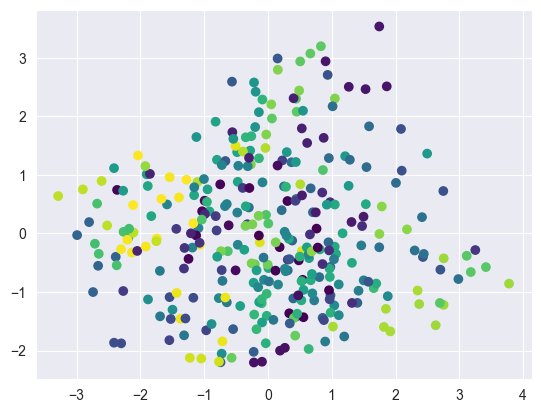

In [168]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
cluster_data =new_dataframe

cluster_data = synthesizer._model._encoder(torch.from_numpy(synthesizer._model.transformer.transform(cluster_data).astype(np.float32)).to(device))[0].detach().cpu().numpy()
labels_vae = KMeans(n_clusters=70).fit_predict(cluster_data)
pca = PCA(n_components=2)

cluster_data_pca = pca.fit_transform(cluster_data)
plt.scatter(cluster_data_pca[:, 0], cluster_data_pca[:, 1], c=labels_vae, cmap='viridis')

# Let's predict MHG

In [50]:
new_dataframe

NameError: name 'new_dataframe' is not defined

To predict MHG I will use the same model as above to get the feature importance.

In [169]:
mhg_model_data = new_dataframe.drop(['Cultivar', 'Repetition'], axis=1)
mhg_model_data['IsSeason1'] = mhg_model_data['Season'] == 1
mhg_model_data = mhg_model_data.drop('Season', axis=1)
mhg_model_data['IsSeason1'] = mhg_model_data['IsSeason1'].apply(int)

mhg_model_data = mhg_model_data.sample(frac=1)
train_data, validation_data = train_test_split(mhg_model_data, test_size=0.1)
train_data = train_data.reset_index()
validation_data = validation_data.reset_index()
X_train = train_data.drop('MHG', axis=1)
y_train = train_data['MHG']
X_validation = validation_data.drop('MHG', axis=1)
y_validation = validation_data['MHG']
X_train.drop('index', axis=1, inplace=True)
X_validation.drop('index', axis=1, inplace=True)

In [170]:
from sklearn.preprocessing import StandardScaler
float_cols = X_train.select_dtypes(include='float64').columns
scaler = StandardScaler()
scaler.fit(X_train[float_cols])
X_train[float_cols] = scaler.transform(X_train[float_cols])
X_validation[float_cols] = scaler.transform(X_validation[float_cols])

In [179]:
import utilities
model = neuralNetwork.SecondSoyBeanNetwork(len(X_train.columns)).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_losses, val_lossses = utilities.train(model, 100, criterion, optimizer, X_train, y_train, X_validation, y_validation)

AttributeError: module 'models.neuralNetwork' has no attribute 'SecondSoyBeanNetwork'

<Axes: >

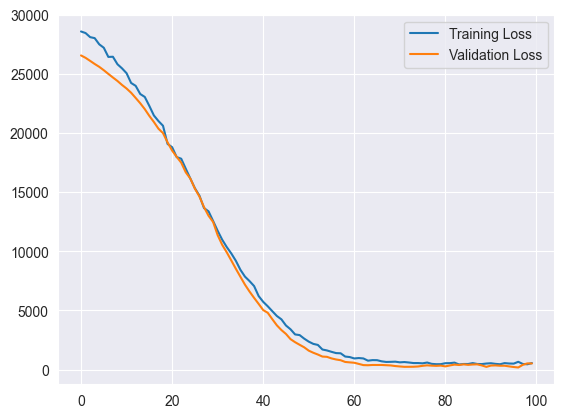

In [172]:
sns.lineplot(train_losses, label='Training Loss')
sns.lineplot(val_lossses, label='Validation Loss')

In [177]:
y_val_pred = model(torch.tensor(X_validation.to_numpy(), dtype=torch.float).to(device)).cpu().detach().numpy().squeeze(1)
aux = pd.DataFrame({'Predicted': y_val_pred, 'Actual': y_validation})

In [178]:
aux

,Predicted,Actual
0,158.533783,194.110000
1,178.945297,201.770000
2,174.144470,169.320000
3,164.092865,148.870000
4,179.013367,171.560000
5,138.771439,146.440000
6,150.299347,130.450000
7,146.926758,161.740000
8,181.176193,149.770000
9,138.880478,196.210000
